In [2]:
import pandas as pd

frame = pd.read_json('..\\Data\\ZIP_code_stats.json', lines=True)
geo_complaints = frame.fillna(0)
geo_complaints.head()

,ZIP code,BankAccount,CreditService,DebtCollection,Zip,City,State,Latitude,Longitude,zipcode,NumReturns,TotalIncome,Loans,NonBank,Transfers
0,77303,2.0,15.0,1.0,77303,Conroe,TX,30.368543,-95.40217,77303,7810,371681,0.0,0.0,0.0
1,55371,4.0,0.0,1.0,55371,Princeton,MN,45.576431,-93.57644,55371,7930,453468,0.0,0.0,0.0
2,79849,0.0,0.0,3.0,79849,San Elizario,TX,31.577344,-106.26720,79849,5390,139911,0.0,0.0,0.0
3,44446,19.0,4.0,11.0,44446,Niles,OH,41.186257,-80.75297,44446,10150,396741,2.0,0.0,0.0
4,11563,48.0,22.0,27.0,11563,Lynbrook,NY,40.656974,-73.67306,11563,11520,1028777,3.0,1.0,1.0


In [3]:
continental_us_complaints = geo_complaints[~geo_complaints['State'].isin(['AK', 'HI'])]

In [4]:
continental_us_complaints.loc[:, 'TotalComplaints'] = continental_us_complaints.BankAccount + \
    continental_us_complaints.CreditService + continental_us_complaints.DebtCollection + \
    continental_us_complaints.Loans + continental_us_complaints.NonBank + continental_us_complaints.Transfers

continental_us_complaints.loc[:, 'ComplaintsPerTaxReturn'] = continental_us_complaints.TotalComplaints / continental_us_complaints.NumReturns


C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:

stats = continental_us_complaints.ComplaintsPerTaxReturn.describe()
# find all zip codes with complaints 2 standard deviations from the statistical average of complaints per tax return
outliers = continental_us_complaints[continental_us_complaints['ComplaintsPerTaxReturn'] > (stats['mean'] + (stats['std'] * 2))]

return_stats = outliers['NumReturns'].describe()
complaint_stats = outliers['TotalComplaints'].describe()

# Remove all records where the number of returns or complaints is one standard deviation below the mean - the very small 
# numbers skew the overall view of the outliers
outliers = outliers[outliers['NumReturns'] > (return_stats['mean'] - (complaint_stats['std']))]
outliers = outliers[outliers['TotalComplaints'] > (complaint_stats['mean'] - (complaint_stats['std']))]


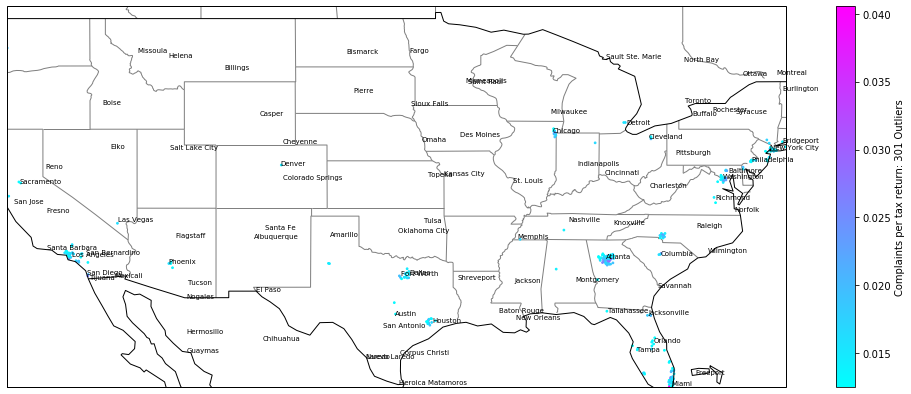

In [6]:
import matplotlib.pyplot as plt
import cartopy.feature
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

plt.figure(figsize=(18, 7))

def isInBox(item):
    return (item.attributes['LATITUDE'] >= outliers.Latitude.min()) and \
        (item.attributes['LATITUDE'] <= outliers.Latitude.max()) and \
        (item.attributes['LONGITUDE'] >= outliers.Longitude.min()) and \
        (item.attributes['LONGITUDE'] <= outliers.Longitude.max())

shp_populated_places = shpreader.Reader('..\\Data\\ne_50m_populated_places')
places = shp_populated_places.records()
us_places = [p for p in places if isInBox(p)]

ax = plt.axes(projection=ccrs.PlateCarree())
BBox = (outliers.Longitude.min(), outliers.Longitude.max(), outliers.Latitude.min(), outliers.Latitude.max())
ax.set_extent(BBox)

# Scatter plot the Long and Lat of outlying complaints, use a colormap to indicate values
plt.scatter(outliers['Longitude'].values, outliers['Latitude'].values, 3, \
            c = outliers['ComplaintsPerTaxReturn'].values, cmap = 'cool')
cbar = plt.colorbar()
cbar.set_label('Complaints per tax return: {} Outliers'.format(len(outliers)))

# Add states
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', \
                                                 facecolor='none')

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, zorder=0, edgecolor='grey')

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 7}

for p in us_places:
    ax.text(p.attributes['LONGITUDE'], p.attributes['LATITUDE'], p.attributes['name_en'], font)

plt.show()


In [7]:
continental_us_complaints.loc[:, 'MeanIncome'] = continental_us_complaints.TotalIncome / continental_us_complaints.NumReturns
continental_us_complaints.head()

,ZIP code,BankAccount,CreditService,DebtCollection,Zip,City,State,Latitude,Longitude,zipcode,NumReturns,TotalIncome,Loans,NonBank,Transfers,TotalComplaints,ComplaintsPerTaxReturn,MeanIncome
0,77303,2.0,15.0,1.0,77303,Conroe,TX,30.368543,-95.40217,77303,7810,371681,0.0,0.0,0.0,18.0,0.002305,47.590397
1,55371,4.0,0.0,1.0,55371,Princeton,MN,45.576431,-93.57644,55371,7930,453468,0.0,0.0,0.0,5.0,0.000631,57.183859
2,79849,0.0,0.0,3.0,79849,San Elizario,TX,31.577344,-106.26720,79849,5390,139911,0.0,0.0,0.0,3.0,0.000557,25.957514
3,44446,19.0,4.0,11.0,44446,Niles,OH,41.186257,-80.75297,44446,10150,396741,2.0,0.0,0.0,36.0,0.003547,39.087783
4,11563,48.0,22.0,27.0,11563,Lynbrook,NY,40.656974,-73.67306,11563,11520,1028777,3.0,1.0,1.0,102.0,0.008854,89.303559


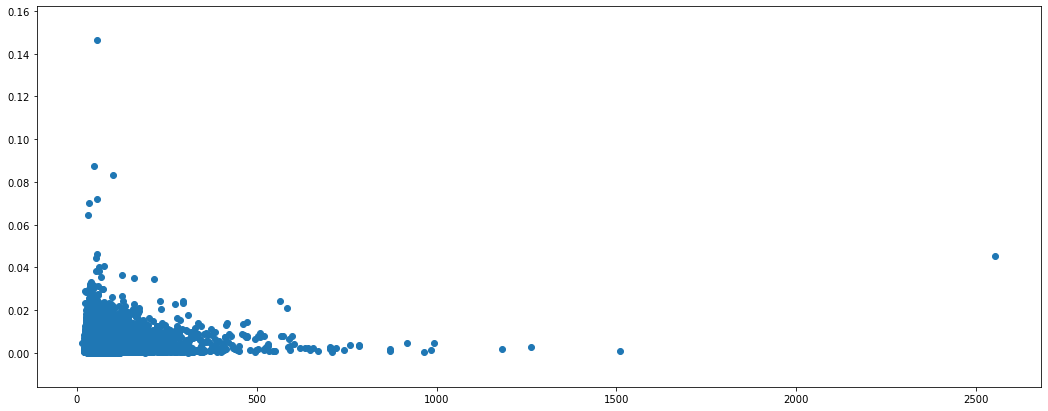

Pearsons correlation: 0.067
Spearmans correlation: 0.044


In [8]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr

plt.figure(figsize=(18, 7))

# Scatter plot the Long and Lat of outlying complaints, use a colormap to indicate values
plt.scatter(continental_us_complaints['MeanIncome'].values, continental_us_complaints['ComplaintsPerTaxReturn'].values)
plt.show()

# calculate pearson correlation coefficient
corr, _ = pearsonr(continental_us_complaints['MeanIncome'].values, continental_us_complaints['ComplaintsPerTaxReturn'].values)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(continental_us_complaints['MeanIncome'].values, continental_us_complaints['ComplaintsPerTaxReturn'].values)
print('Spearmans correlation: %.3f' % corr)


In [35]:
from sklearn.cluster import KMeans
import numpy as np

# Find all non-zero complaints
non_zero_complaints = continental_us_complaints[continental_us_complaints['TotalComplaints'] > 0]

# Combine the two lists of long and lat values into a 2-dimensional array with two columns
data = np.array(list(zip(non_zero_complaints['Longitude'].values, non_zero_complaints['Latitude'].values)))

# Create a KMeans cluster model, configured to look for 15 clusters
model = KMeans(n_clusters=15)
# Fit the model to the data, scaling it to ensure that the data is normalized
model = model.fit(data)

continental_us_complaints.loc[:, 'Cluster'] = model.labels_.astype(float)


C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
# Group the data frame by month and item and extract a number of stats from each group
groupedClusters = continental_us_complaints.groupby('Cluster').agg(
    {
         'BankAccount':sum,
         'CreditService':sum,
         'DebtCollection':sum,
         'Latitude': 'mean', 
         'Longitude': 'mean',
         'Loans':sum,
         'NonBank': sum,
         'Transfers': sum,
        
    })

groupedClusters.loc[:, 'MostComplaints'] = groupedClusters.idxmax(axis=1)


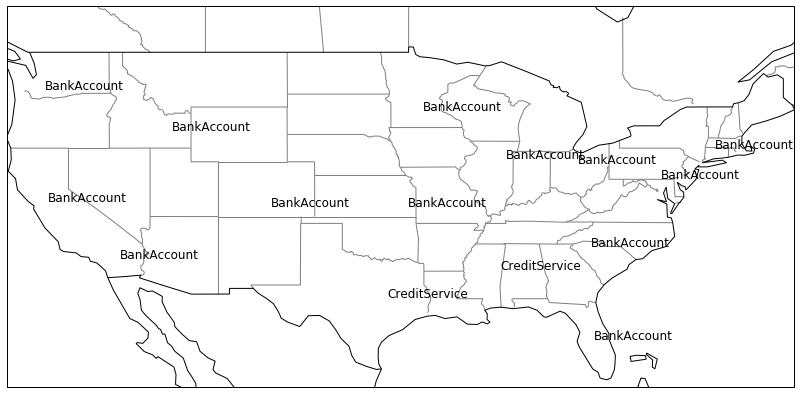

In [37]:
import matplotlib.pyplot as plt
import cartopy.feature
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

plt.figure(figsize=(18, 7))

def isInBox(item):
    return (item.attributes['LATITUDE'] >= continental_us_complaints.Latitude.min()) and \
        (item.attributes['LATITUDE'] <= continental_us_complaints.Latitude.max()) and \
        (item.attributes['LONGITUDE'] >= continental_us_complaints.Longitude.min()) and \
        (item.attributes['LONGITUDE'] <= continental_us_complaints.Longitude.max())

shp_populated_places = shpreader.Reader('..\\Data\\ne_50m_populated_places')
places = shp_populated_places.records()
us_places = [p for p in places if isInBox(p)]

ax = plt.axes(projection=ccrs.PlateCarree())
BBox = (continental_us_complaints.Longitude.min(), continental_us_complaints.Longitude.max(), \
        continental_us_complaints.Latitude.min(), continental_us_complaints.Latitude.max())
ax.set_extent(BBox)

# Add states
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', \
                                                 facecolor='none')

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, zorder=0, edgecolor='grey')

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}
    
for index, row in groupedClusters.iterrows():
    ax.text(row['Longitude'], row['Latitude'], row['MostComplaints'], font)
    
plt.show()
